# Unitary cost function gradient descent on MPO - initial conditions

Created 25/10/2024

Objectives:
* Investigate convergence of unitary cost grad descent on MPO with respect to initial conditions. Other work suggests that the magnitude of the input unitary is very important.

# Package imports

In [1]:
import sys

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
from functools import reduce

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import re

# Load data

In [6]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [7]:
f_name = DATA_DIR + r"/0_90.h5"

In [8]:
f_name

'../../data/transverse_cluster_200_site_dmrg/0_90.h5'

In [9]:
with h5py.File(f_name, 'r') as f:
    data = hdf5_io.load_from_hdf5(f)
    test_psi = data['wavefunction']

# Definitons

In [10]:
NUM_SITES=5
BOND_DIMENSION=4
PHYSICAL_DIMENSION=2
LEARNING_RATE = 0.01

In [11]:
total_dimension = PHYSICAL_DIMENSION**NUM_SITES

In [12]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [13]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

In [14]:
def generate_random_w_tensor(dims):
    x1 = np.random.rand(*dims)
    x2 = 1j*np.random.rand(*dims)

    return x1 + x2

In [15]:
edge_dims = [PHYSICAL_DIMENSION,]*2 + [BOND_DIMENSION,]
inner_dims = edge_dims + [BOND_DIMENSION,]

In [16]:
w = generate_random_w_tensor(edge_dims)

In [17]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vR'])

In [18]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>

In [19]:
w_tensors = [w_tensor,]

In [20]:
for _ in range(NUM_SITES-2):
    w = generate_random_w_tensor(inner_dims)
    w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
    
    w_tensors.append(w_tensor)

In [21]:
w = generate_random_w_tensor(edge_dims)

In [22]:
w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL'])

In [23]:
w_tensor

<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>

In [24]:
w_tensors.append(w_tensor)

In [25]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

## Functions

In [26]:
def get_physical_dim(tensor, p_label='p'):
    index = tensor.get_leg_index(p_label)
    dim = tensor.shape[index]
    return dim

In [542]:
def mpo_frobenius_inner_product(mpo1_tensors, mpo2_tensors=None):
    if mpo2_tensors is None:
        mpo2_tensors = mpo1_tensors

    w1 = mpo1_tensors[0]
    dim = get_physical_dim(w1, p_label='p')
    w2 = mpo2_tensors[0]

    t = npc.tensordot(w1, w2.conj(), [['p', 'p*'], ['p*', 'p']])
    #t /= dim

    for w1, w2 in zip(mpo1_tensors[1:], mpo2_tensors[1:]):
        dim = get_physical_dim(w1, p_label='p')

        t = npc.tensordot(t, w1, [['vR', ], ['vL']])
        t = npc.tensordot(t, w2.conj(), [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']])
        #t /= dim

    return t.real

In [28]:
def order_two_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])

    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR']])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

In [29]:
def order_four_right_tensors(w_tensors):
    out = list()

    w = w_tensors[-1]
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vL', 'vL*'], ['vL1', 'vL1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    out.append(t)

    for w in w_tensors[-2:0:-1]:
        t = npc.tensordot(t, w, [['vL',], ['vR',]])
        t = npc.tensordot(t, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])

        w = w.replace_label('vL', 'vL1')
    
        t = npc.tensordot(t, w, [['vL1', 'p',], ['vR', 'p*']])
        t = npc.tensordot(t, w.conj(), [['vL1*', 'p', 'p*'], ['vR*', 'p*', 'p']])

        out.append(t)

    return out[::-1]

## Rescale tensor

In [30]:
mpo_frobenius_inner_product(w_tensors)

(2402418.212706654+5.820766091346741e-11j)

In [31]:
scale_factor = np.power(
    mpo_frobenius_inner_product(w_tensors).real,
    -1/(2*NUM_SITES)
)

In [32]:
scale_factor

0.23010981265664787

In [33]:
for w in w_tensors:
    w *= scale_factor

In [34]:
mpo_frobenius_inner_product(w_tensors)

(0.9999999999999988+0j)

## Sweep function

In [35]:
def mpo_tensor_raw_to_gradient(raw_mpo_tensor, gradient_target_tensor):
    leg_labels = raw_mpo_tensor.get_leg_labels()

    old_new_leg_label_pairs = [
        ('vL*', 'vR'),
        ('vR*', 'vL'),
        ('vL1*', 'vR'),
        ('vR1*', 'vL'),
    ]

    for old, new in old_new_leg_label_pairs:
        if old in leg_labels:
            raw_mpo_tensor.ireplace_label(old, new)

    out = npc.Array.from_ndarray_trivial(
        raw_mpo_tensor.to_ndarray(),
        labels=raw_mpo_tensor.get_leg_labels()
    )

    out.itranspose(gradient_target_tensor.get_leg_labels())

    return out

In [36]:
def update_mpo_score(raw_gradient_mpo_tensor, gradient_target_tensor,
                     score_list,
                     virtual_legs=[['vL*', 'vR*',], ['vR*', 'vL*',]]):
    raw_legs, target_legs = virtual_legs

    score = npc.tensordot(
        raw_gradient_mpo_tensor,
        gradient_target_tensor.conj(),
        [['p', 'p*', *raw_legs], ['p*', 'p', *target_legs]]
    )

    score_list.append(score.real)

In [37]:
def unitary_mpo_gradient_descent_sweep(mpo_tensors, learning_rate):
    # Initialise variables
    right_two_tensors = order_two_right_tensors(mpo_tensors)
    right_four_tensors = order_four_right_tensors(mpo_tensors)

    left_two_tensors = list()
    left_four_tensors = list()

    order_two_scores = list()
    order_four_scores = list()

    num_sites = len(mpo_tensors)

    # Leftmost site
    w = mpo_tensors[0]
    t = right_two_tensors[0]

    # Second order terms
    grad_2 = npc.tensordot(t, w, [['vL'], ['vR',]])

    update_mpo_score(grad_2, w, order_two_scores, [['vL*',], ['vR*',]])

    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    # Fourth order terms
    t = right_four_tensors[0]

    grad_4 = npc.tensordot(t, w, [['vL'], ['vR',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vL1', 'p'], ['vR', 'p*']])

    update_mpo_score(grad_4, w, order_four_scores, [['vL1*',], ['vR*',]])

    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    # Update tensor
    mpo_tensors[0] = w + learning_rate*(grad_2 - grad_4)

    # Create and save left tensors
    w = mpo_tensors[0]

    t = npc.tensordot(w, w.conj(), [['p', 'p*'], ['p*', 'p']])
    left_two_tensors.append(t)
    
    t = npc.tensordot(w, w.conj(), [['p',], ['p*',]])
    t.ireplace_labels(['vR', 'vR*'], ['vR1', 'vR1*'])
    t = npc.tensordot(t, w, [['p',], ['p*',]])
    t = npc.tensordot(t, w.conj(), [['p', 'p*'], ['p*', 'p']])
    
    left_four_tensors.append(t)

    # Inner sites
    for i in range(1, num_sites-1):
        w=mpo_tensors[i]
        right_two_tensor = right_two_tensors[i]
        right_four_tensor = right_four_tensors[i]

        # Order two terms
        left_two_tensor = left_two_tensors[-1]

        grad_2 = npc.tensordot(right_two_tensor, w, [['vL'], ['vR',]])
        grad_2 = npc.tensordot(grad_2, left_two_tensor, [['vL'], ['vR',]])

        update_mpo_score(grad_2, w, order_two_scores)
        grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

        # Order four terms
        left_four_tensor = left_four_tensors[-1]

        grad_4 = npc.tensordot(right_four_tensor, w, [['vL'], ['vR',]])
        grad_4 = npc.tensordot(grad_4, w.conj(), [['vL*', 'p'], ['vR*', 'p*']])
        grad_4 = npc.tensordot(
            grad_4,
            w.replace_label('vL', 'vL1'),
            [['vL1', 'p'], ['vR', 'p*']]
        )
        
        grad_4 = npc.tensordot(
            grad_4,
            left_four_tensor,
            [['vL', 'vL*', 'vL1'], ['vR', 'vR*', 'vR1']]
        )

        update_mpo_score(grad_4, w, order_four_scores, [['vL1*', 'vR1*',], ['vR*', 'vL*',]])
        grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

        mpo_tensors[i] = w + learning_rate*(grad_2 - grad_4)

        w = mpo_tensors[i]

        # Update left tensors
        t = npc.tensordot(left_two_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(
            t,
            w.conj(),
            [['vR*', 'p', 'p*'], ['vL*', 'p*', 'p']]
        )
        
        left_two_tensors.append(t)
        
        t = npc.tensordot(left_four_tensor, w, [['vR',], ['vL']])
        t = npc.tensordot(t, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
        t = npc.tensordot(
            t,
            w.replace_label('vR', 'vR1'),
            [['p', 'vR1'], ['p*', 'vL']]
        )
        t = npc.tensordot(
            t,
            w.conj().replace_label('vR*', 'vR1*'),
            [['p', 'p*', 'vR1*'], ['p*', 'p', 'vL*']]
        )
        
        left_four_tensors.append(t)

    # Last site
    left_two_tensor = left_two_tensors[-1]
    w = mpo_tensors[-1]
    
    grad_2 = npc.tensordot(left_two_tensor, w, [['vR'], ['vL',]])
    
    update_mpo_score(grad_2, w, order_two_scores, [['vR*',], ['vL*',]])
    grad_2 = mpo_tensor_raw_to_gradient(grad_2, w)

    left_four_tensor = left_four_tensors[-1]
    
    grad_4 = npc.tensordot(left_four_tensor, w, [['vR'], ['vL',]])
    grad_4 = npc.tensordot(grad_4, w.conj(), [['vR*', 'p'], ['vL*', 'p*']])
    grad_4 = npc.tensordot(grad_4, w, [['vR1', 'p'], ['vL', 'p*']])
    
    update_mpo_score(grad_4, w, order_four_scores, [['vR1*',], ['vL*',]])
    grad_4 = mpo_tensor_raw_to_gradient(grad_4, w)

    mpo_tensors[-1] = w + learning_rate*(grad_2 - grad_4)

    return (order_two_scores, order_four_scores)

In [38]:
def unitarity_error_from_subscores(order_two_score, order_four_score, dimension):
    return order_four_score - 2*order_two_score + dimension

In [39]:
def unitarity_errors_from_subscores(order_two_scores, order_four_scores,
                                    dimension):
    out = [
        unitarity_error_from_subscores(o2, o4, dimension)
        for o2, o4 in zip(order_two_scores, order_four_scores)
    ]
    
    return out

### Rescale and get mpo tensors

In [91]:
def rescale_mpo_tensors(mpo_tensors, new_norm):
    num_sites = len(mpo_tensors)

    old_norm = mpo_frobenius_inner_product(mpo_tensors).real
    
    scale_factor = np.power(
        new_norm/old_norm,
        1/(2*num_sites)
    )

    for i in range(num_sites):
        mpo_tensors[i] = scale_factor*mpo_tensors[i]

In [167]:
def get_random_mpo_tensors(num_sites=NUM_SITES, norm=None):
    """
    Needs more arguments
    """

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vR']
    )

    w_tensors = [w_tensor,]

    for _ in range(num_sites-2):
        w = generate_random_w_tensor(inner_dims)
        w_tensor = npc.Array.from_ndarray_trivial(w, labels=['p', 'p*', 'vL', 'vR'])
        
        w_tensors.append(w_tensor)

    w = generate_random_w_tensor(edge_dims)
    w_tensor = npc.Array.from_ndarray_trivial(
        w,
        labels=['p', 'p*', 'vL']
    )
    w_tensors.append(w_tensor)

    if norm is not None:
        rescale_mpo_tensors(w_tensors, norm)

    return w_tensors

### Identity w_tensors

In [293]:
def get_identity_w_tensor(physical_dim, left_virtual_dim=None, right_virtual_dim=None):
    diagonal = np.ones(physical_dim, dtype='complex')
    identity_matrix = np.diag(diagonal)
    
    if (left_virtual_dim is None) and (right_virtual_dim is None):
        w_tensor = npc.Array.from_ndarray_trivial(
            identity_matrix,
            labels=['p', 'p*']
        )
    elif right_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL']
        )
    elif left_virtual_dim is None:
        X = np.zeros(
            (physical_dim, physical_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vR']
        )
    else:
        X = np.zeros(
            (physical_dim, physical_dim, left_virtual_dim, right_virtual_dim),
            dtype='complex'
        )
        X[...,0,0] = identity_matrix
        w_tensor = npc.Array.from_ndarray_trivial(
            X,
            labels=['p', 'p*', 'vL', 'vR']
        )

    return w_tensor

In [312]:
def get_identity_mpo_tensors(physical_dims, virtual_dims):
    """
    Needs more comments, docs!

    Often physical dims, virtual dims will be the same, so could add
    optional behaviour...
    """

    w_tensors = [
        get_identity_w_tensor(p_dim, *v_dims)
        for p_dim, v_dims in zip(physical_dims, virtual_dims)
    ]

    return w_tensors

# Analysis

Test

In [106]:
w_tensors = get_random_mpo_tensors(norm=1)

In [107]:
mpo_frobenius_inner_product(w_tensors)

(0.9999999999999993+2.7755575615628914e-17j)

In [108]:
learning_rate = 0.02
unitarity_errors = list()
num_iterations = 500

In [109]:
total_dimension = 2**NUM_SITES

In [110]:
for _ in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    unitarity_errors.append(
        unitarity_errors_from_subscores(o2, o4, total_dimension)
    )

In [111]:
unitary_errors_array = np.array(unitarity_errors)

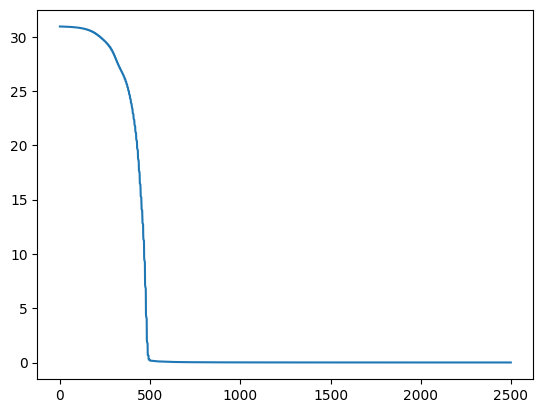

In [112]:
plt.plot(unitary_errors_array.flatten())

In [113]:
unitary_errors_array[-1]

array([0.00237077, 0.00237041, 0.00236844, 0.00236704, 0.00236598])

In [114]:
for _ in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, 0.5)

    unitarity_errors.append(
        unitarity_errors_from_subscores(o2, o4, total_dimension)
    )

## Learning rates & initial norm

### Sweep 1

In [119]:
total_dimension

32

In [120]:
learning_rates = [0.01, 0.03, 0.1]
initial_norms = [1, np.sqrt(total_dimension), total_dimension]

In [123]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

In [126]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/1162835907.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


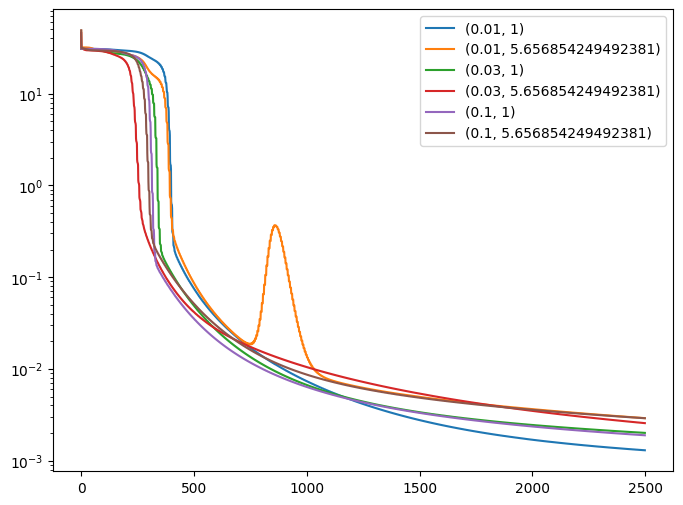

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        if (i_norm != 2):
            label = f"({lr}, {norm})"
            ax.plot(
                unitary_errors_array[i_lr, i_norm].flatten(),
                label=label
            )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/2269052125.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


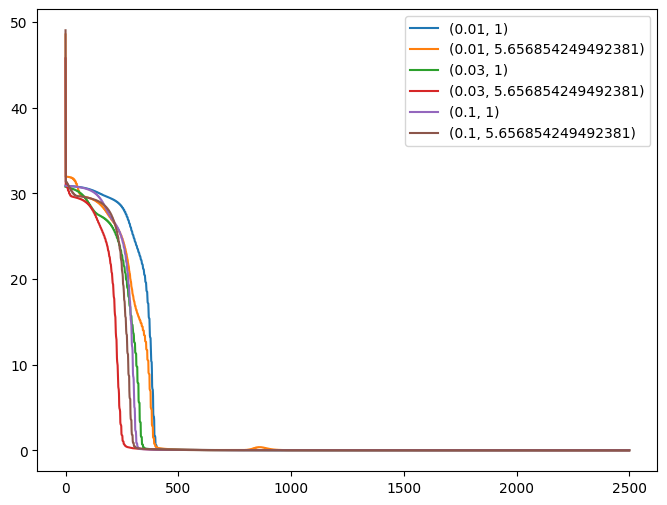

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        if (i_norm != 2):
            label = f"({lr}, {norm})"
            ax.plot(
                unitary_errors_array[i_lr, i_norm].flatten(),
                label=label
            )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

In [142]:
unitary_errors_array[:,-1]

array([[[8.98364363e+002, 1.91799249e+008, 2.76217905e+032,
         1.60399505e+153,             nan],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan],
        ...,
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan]],

       [[8.37196151e+002, 7.36962834e+007, 2.63994163e+030,
         1.21300451e+143,             nan],
        [            nan,             nan,             nan,
                     nan,             nan],
        [            nan,             nan,             nan,
                     nan,             nan],
        ...,
        [            nan,           

### Sweep 2

In [145]:
learning_rates = [0.01, 0.03, 0.1]
initial_norms = [0.01, 0.1, 1]

In [146]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

In [147]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/198488462.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


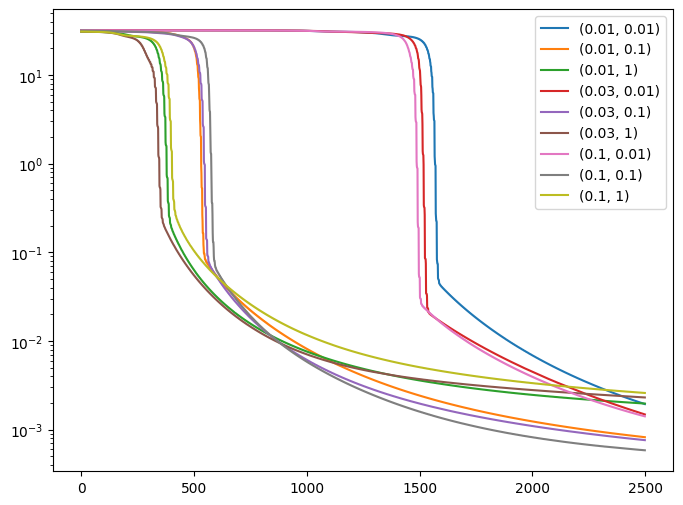

In [149]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/2902148041.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


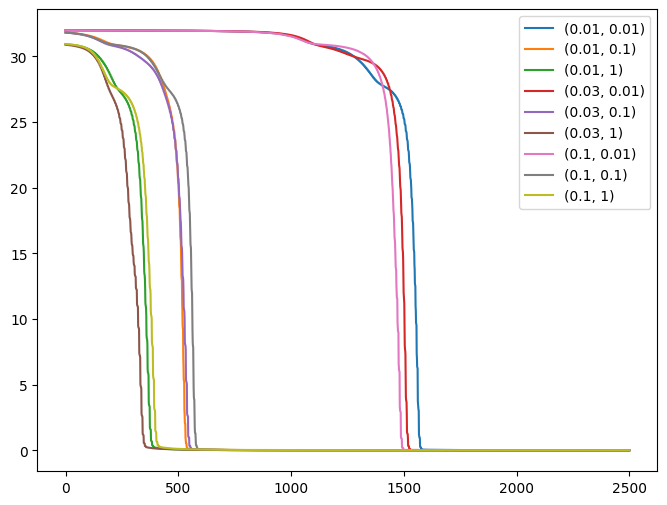

In [150]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

Initialization value seems more important to convergence than learning rate!

### Sweep 3

In [151]:
learning_rates = [0.03, ]
initial_norms = [0.01, 0.1, 1, 2, 5, 8, 12, 20]

In [152]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

In [153]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)


In [159]:
unitary_errors_array[0, -2:, -1]

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/2308743603.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


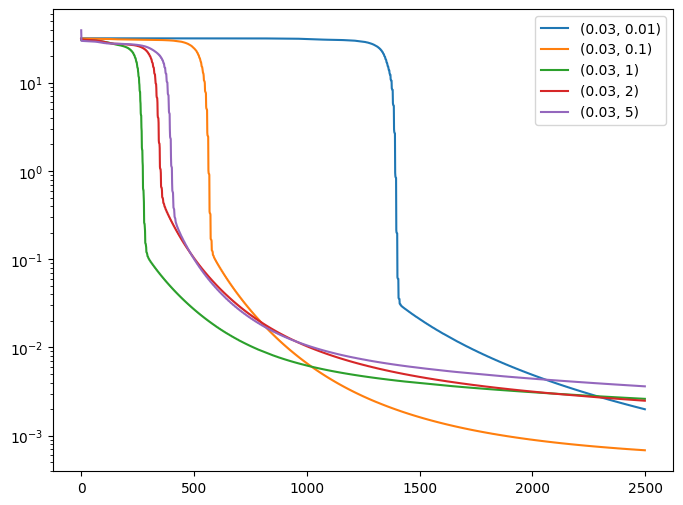

In [160]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms[:-3]):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/1142730447.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


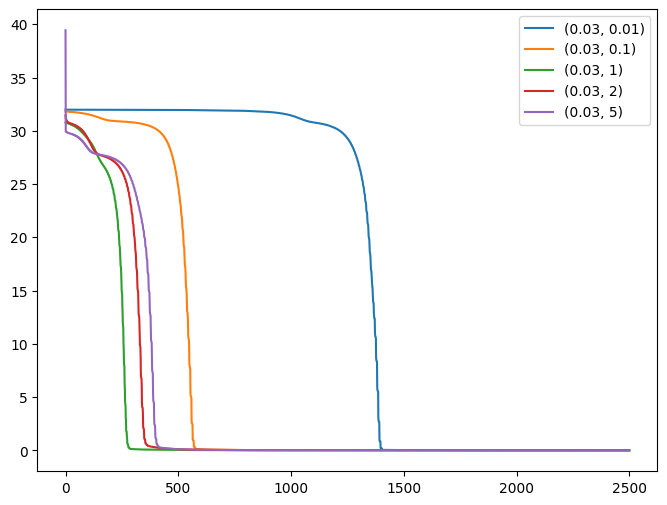

In [161]:
fig, ax = plt.subplots(figsize=(8, 6))

for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms[:-3]):
        label = f"({lr}, {norm})"
        ax.plot(
            unitary_errors_array[i_lr, i_norm].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

Initial norm of 1 giving best results. Coincidence...?

## Num sites

### Sweep 1

In [182]:
learning_rate = 0.03
initial_norm = 1

num_sites_list = list(range(2, 12))

In [171]:
array_shape = (
    len(num_sites_list),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

unitary_errors_arrays = list()

for n in num_sites_list:
    unitary_errors_arrays.append(np.zeros((num_iterations, n)))

In [172]:
for i_num_sites, num_sites in enumerate(num_sites_list):
    print((i_num_sites, num_sites))
    
    w_tensors = get_random_mpo_tensors(num_sites, initial_norm)
    
    for i_iteration in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

        total_dimension = 2**num_sites
        unitarity_errors = unitarity_errors_from_subscores(
            o2, o4, total_dimension
        )

        unitary_errors_arrays[i_num_sites][i_iteration] = unitarity_errors

(0, 2)
(1, 3)
(2, 4)
(3, 5)
(4, 6)
(5, 7)
(6, 8)
(7, 9)
(8, 10)
(9, 11)


In [175]:
unitary_errors_arrays[-1][-1]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [181]:
unitary_errors_arrays[-7][-1]

array([0.0019067 , 0.00190647, 0.0019059 , 0.00190499, 0.00190413])

In [183]:
unitary_errors_arrays[-6][-1]

array([nan, nan, nan, nan, nan, nan])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/2320087683.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


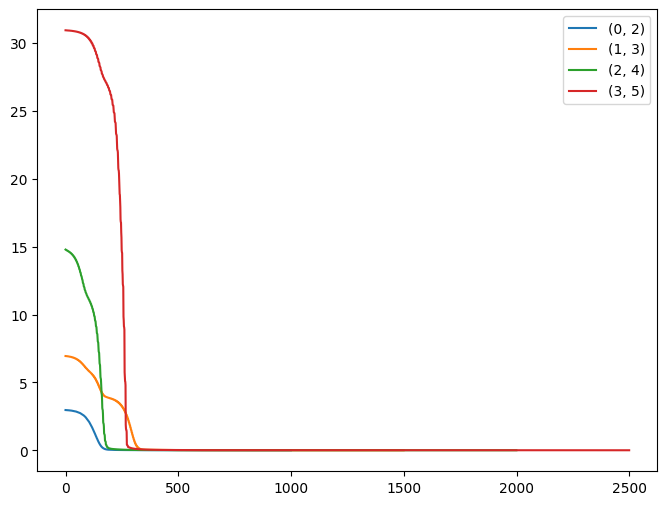

In [185]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[:-6]):
        label = f"({i}, {num_sites})"
        ax.plot(
            unitary_errors_arrays[i].flatten(),
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

### Sweep 2

In [186]:
learning_rate = 0.03
initial_norm = 0.001

num_sites_list = list(range(2, 12))

In [187]:
array_shape = (
    len(num_sites_list),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

unitary_errors_arrays = list()

for n in num_sites_list:
    unitary_errors_arrays.append(np.zeros((num_iterations, n)))

In [188]:
for i_num_sites, num_sites in enumerate(num_sites_list):
    print((i_num_sites, num_sites))
    
    w_tensors = get_random_mpo_tensors(num_sites, initial_norm)
    
    for i_iteration in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

        total_dimension = 2**num_sites
        unitarity_errors = unitarity_errors_from_subscores(
            o2, o4, total_dimension
        )

        unitary_errors_arrays[i_num_sites][i_iteration] = unitarity_errors

(0, 2)
(1, 3)
(2, 4)
(3, 5)
(4, 6)
(5, 7)
(6, 8)
(7, 9)
(8, 10)
(9, 11)


In [192]:
unitary_errors_arrays[0][-1]

array([3.26867745, 3.25372154])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/1956836463.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


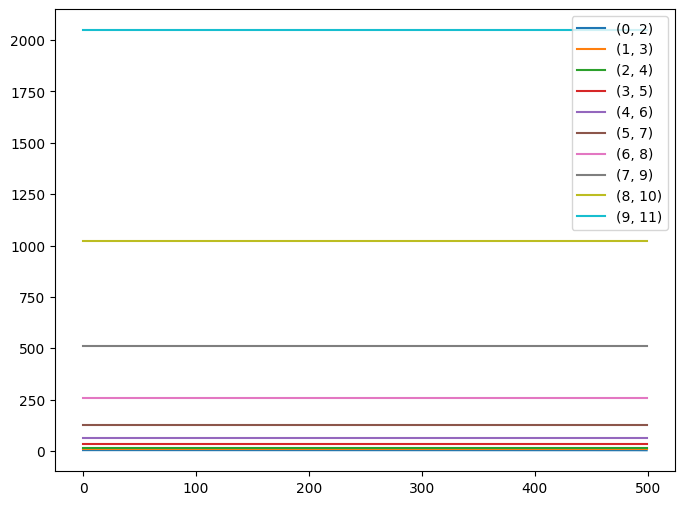

In [193]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list):
        label = f"({i}, {num_sites})"
        ax.plot(
            unitary_errors_arrays[i][:,-1],
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/3478168917.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


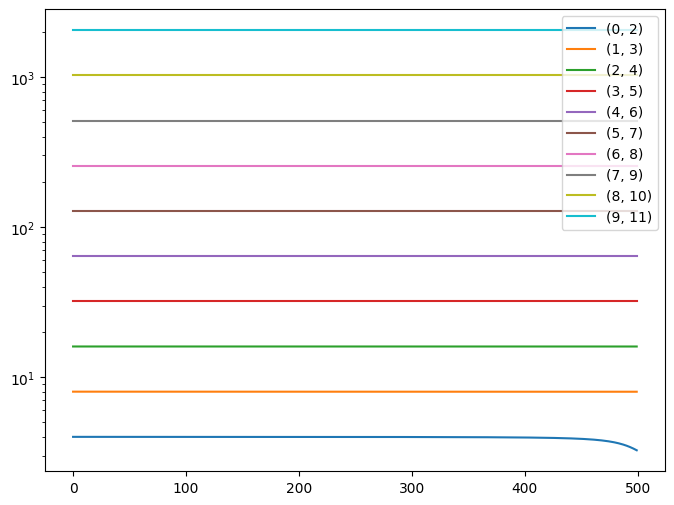

In [194]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list):
        label = f"({i}, {num_sites})"
        ax.plot(
            unitary_errors_arrays[i][:,-1],
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

### Sweep 3

In [195]:
learning_rate = 0.03
initial_norm = 0.01

num_sites_list = list(range(2, 12))

In [196]:
array_shape = (
    len(num_sites_list),
    num_iterations,
    NUM_SITES
)

unitary_errors_array = np.zeros(array_shape)

unitary_errors_arrays = list()

for n in num_sites_list:
    unitary_errors_arrays.append(np.zeros((num_iterations, n)))

In [197]:
for i_num_sites, num_sites in enumerate(num_sites_list):
    print((i_num_sites, num_sites))
    
    w_tensors = get_random_mpo_tensors(num_sites, initial_norm)
    
    for i_iteration in range(num_iterations):
        o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

        total_dimension = 2**num_sites
        unitarity_errors = unitarity_errors_from_subscores(
            o2, o4, total_dimension
        )

        unitary_errors_arrays[i_num_sites][i_iteration] = unitarity_errors

(0, 2)
(1, 3)
(2, 4)
(3, 5)
(4, 6)
(5, 7)
(6, 8)
(7, 9)
(8, 10)
(9, 11)


In [198]:
unitary_errors_arrays[0][-1]

array([0.00014334, 0.00014322])

In [205]:
unitary_errors_arrays[-7][-1]

array([0.00030182, 0.00030163, 0.00030146, 0.00030127, 0.00030075])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/658323312.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


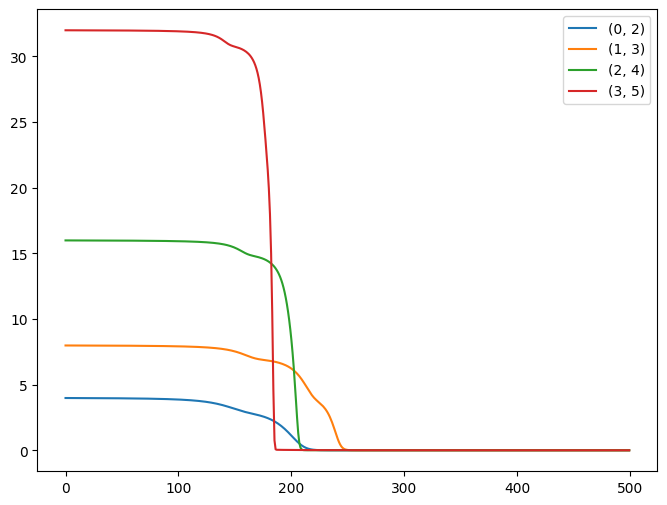

In [206]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[:-6]):
        label = f"({i}, {num_sites})"
        ax.plot(
            unitary_errors_arrays[i][:,-1],
            label=label
        )

#ax.set_ylim(2*total_dimension)
#ax.set_yscale('log')

ax.legend()

fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/2587770593.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


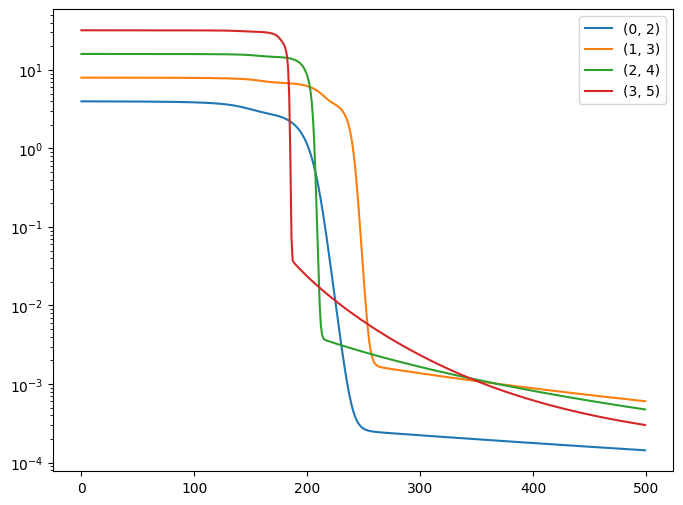

In [207]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, num_sites in enumerate(num_sites_list[:-6]):
        label = f"({i}, {num_sites})"
        ax.plot(
            unitary_errors_arrays[i][:,-1],
            label=label
        )

#ax.set_ylim(2*total_dimension)
ax.set_yscale('log')

ax.legend()

fig.show()

Finding any parameters that converge for more than 5 sites seems challenging.

## 6 sites

### Sweep 1

In [208]:
num_sites = 6

In [209]:
total_dimension = 2**num_sites

In [210]:
learning_rates = [0.01, 0.03, 0.1]
initial_norms = [0.01, 0.1, 1]

In [211]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    num_sites
)

unitary_errors_array = np.zeros(array_shape)

In [212]:
for i_lr, lr in enumerate(learning_rates):
    for i_norm, norm in enumerate(initial_norms):
        print((i_lr, i_norm))
        
        w_tensors = get_random_mpo_tensors(num_sites, norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

(0, 0)
(0, 1)
(0, 2)
(1, 0)
(1, 1)
(1, 2)
(2, 0)
(2, 1)
(2, 2)


In [213]:
unitary_errors_array[..., -1, -1]

array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]])

### Sweep 2

In [214]:
num_sites = 6

In [215]:
total_dimension = 2**num_sites

In [234]:
learning_rates = np.logspace(-5, -1, 20)
initial_norms = np.logspace(-5, -1, 20)

In [235]:
num_iterations = 100

In [236]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    num_sites
)

unitary_errors_array = np.zeros(array_shape)

In [232]:
def contains_nan(values):
    return any(np.isnan(x) for x in values)

In [237]:
for i_lr, lr in enumerate(learning_rates):
    print(i_lr)
    for i_norm, norm in enumerate(initial_norms):
        
        w_tensors = get_random_mpo_tensors(num_sites, norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            if contains_nan(unitarity_errors):
                print('Nan!')
                break

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

0
Nan!
1
Nan!
Nan!
2
Nan!
Nan!
3
Nan!
Nan!
4
Nan!
Nan!
5
Nan!
6
Nan!
7
Nan!
8
Nan!
9
Nan!
Nan!
10
Nan!
11
Nan!
12
Nan!
Nan!
13
14
Nan!
Nan!
15
Nan!
Nan!
16
Nan!
17
Nan!
Nan!
18
Nan!
Nan!
19
Nan!


In [239]:
np.round(unitary_errors_array[..., -1, -1], 3)

array([[6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.40000000e+01,
        6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.39990000e+01,
        6.39990000e+01, 6.39980000e+01, 6.39970000e+01, 6.39940000e+01,
        6.39890000e+01, 6.39770000e+01, 6.39220000e+01, 6.26660000e+01,
        3.21590000e+01, 7.71700000e+00, 1.14800000e+01, 0.00000000e+00],
       [6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.40000000e+01,
        6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.39990000e+01,
        6.39990000e+01, 6.39980000e+01, 6.39970000e+01, 6.39950000e+01,
        6.39890000e+01, 6.39760000e+01, 6.39160000e+01, 6.24820000e+01,
        6.13660000e+01, 4.34800000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.40000000e+01,
        6.40000000e+01, 6.40000000e+01, 6.40000000e+01, 6.39990000e+01,
        6.39990000e+01, 6.39980000e+01, 6.39970000e+01, 6.39940000e+01,
        6.39890000e+01, 6.39740000e+01, 6.39340000e+01, 6.2736

In [241]:
np.max(unitary_errors_array[..., -1, -1])

4.9352904778496775e+97

In [242]:
final_errors_array = unitary_errors_array[..., -1, -1]

In [243]:
for i, l in enumerate(final_errors_array):
    for j, x in enumerate(l):
        if x > 1000:
            final_errors_array[i,j]=0

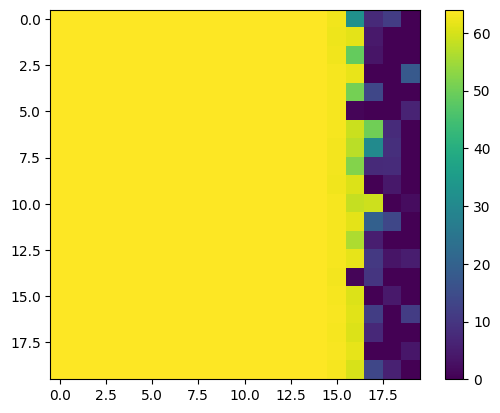

In [245]:
plt.imshow(final_errors_array)
plt.colorbar()

In [246]:
initial_norms[16]

0.023357214690901212

In [266]:
initial_norms[18]

0.00012742749857031348

In [267]:
initial_norms = np.logspace(-5, -1, 20)

In [268]:
initial_norms[16]

0.023357214690901212

In [269]:
initial_norms[18]

0.06158482110660261

Hard line at norm of 0.02 roughly.

### Sweep 3

In [270]:
num_sites = 6

In [271]:
total_dimension = 2**num_sites

In [272]:
learning_rates = np.logspace(-5, -1, 20)
initial_norms = np.logspace(-2, -1, 20)

In [273]:
num_iterations = 100

In [274]:
array_shape = (
    len(learning_rates),
    len(initial_norms),
    num_iterations,
    num_sites
)

unitary_errors_array = np.zeros(array_shape)

In [275]:
def contains_nan(values):
    return any(np.isnan(x) for x in values)

In [276]:
for i_lr, lr in enumerate(learning_rates):
    print(i_lr)
    for i_norm, norm in enumerate(initial_norms):
        
        w_tensors = get_random_mpo_tensors(num_sites, norm)
        
        for i_iteration in range(num_iterations):
            o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)
        
            unitarity_errors = unitarity_errors_from_subscores(
                o2, o4, total_dimension
            )

            if contains_nan(unitarity_errors):
                print('Nan!')
                break

            unitary_errors_array[i_lr, i_norm, i_iteration] = unitarity_errors

0
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
1
Nan!
Nan!
Nan!
Nan!
2
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
3
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
4
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
5
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
6
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
7
Nan!
Nan!
Nan!
Nan!
8
Nan!
Nan!
Nan!
9
Nan!
Nan!
Nan!
10
Nan!
Nan!
Nan!
Nan!
11
Nan!
Nan!
Nan!
Nan!
12
Nan!
Nan!
Nan!
Nan!
Nan!
13
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
14
Nan!
Nan!
15
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
16
Nan!
Nan!
Nan!
Nan!
17
Nan!
Nan!
Nan!


/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_21512/182317212.py:2: RuntimeWarning: overflow encountered in scalar multiply
  return order_four_score - 2*order_two_score + dimension


Nan!
Nan!
18
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
Nan!
19
Nan!
Nan!
Nan!
Nan!
Nan!


In [283]:
unitary_errors_array[..., -1, -1]

array([[63.89336616, 63.67715496, 63.70260429, 62.91751701, 62.88783759,
        62.01693122, 61.25480491, 58.60275766, 32.75017979, 61.35420461,
         0.        ,  0.        ,  0.30422125,  0.        ,  0.        ,
         6.13591836,  4.2278767 ,  0.        ,  0.        ,  0.        ],
       [63.89925556, 63.8231749 , 63.33099279, 62.77013607, 62.59990457,
        62.42951243, 61.92298347, 56.38592458, 18.60233984, 26.53226571,
        28.97463395, 28.00862955,  0.        ,  0.        ,  0.        ,
         5.77422379,  2.64570501,  4.731748  ,  3.5148635 ,  0.        ],
       [63.87382356, 63.82599822, 63.53636964, 62.8418983 , 62.63217754,
        62.6405284 , 62.69359851, 56.41099771,  1.95202178,  0.68126164,
         0.        ,  0.        ,  0.        ,  0.        ,  6.4947209 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [63.90619917, 63.74890886, 63.44288612, 63.08872573, 62.54661892,
        62.68411345, 60.43669458, 59.38126958,  

In [278]:
np.max(unitary_errors_array[..., -1, -1])

4.678693734562637e+18

In [284]:
final_errors_array = unitary_errors_array[..., -1, -1]

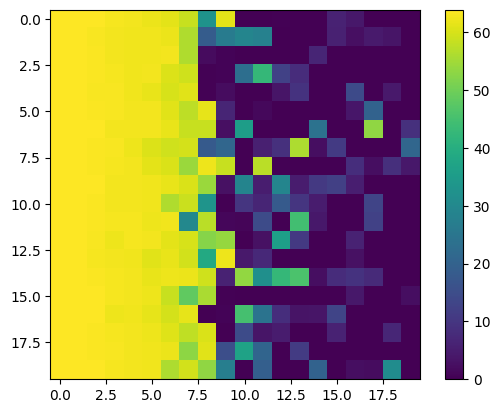

In [285]:
plt.imshow(final_errors_array)
plt.colorbar()

In [246]:
initial_norms[16]

0.023357214690901212

## Identity test case

In [306]:
num_sites = 6

In [307]:
total_dimension = 2**num_sites

In [316]:
learning_rate = 0.03

In [315]:
num_iterations = 50

In [309]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites -2 ) + [(4, None),]

In [313]:
w_tensors = get_identity_mpo_tensors(physical_dims, virtual_dims)

In [314]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [317]:
unitary_errors = list()

In [319]:
for i_iteration in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    unitarity_errors = unitarity_errors_from_subscores(
        o2, o4, total_dimension
    )

    unitary_errors.append(unitarity_errors)

In [320]:
unitary_errors_array = np.array(unitary_errors)

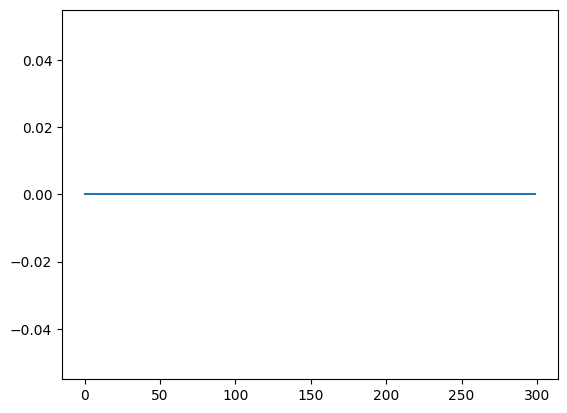

In [321]:
plt.plot(unitary_errors_array.flatten())

In [322]:
unitary_errors_array[0]

array([0., 0., 0., 0., 0., 0.])

In [323]:
unitary_errors_array[-1]

array([0., 0., 0., 0., 0., 0.])

## Perturbation on identity

Note that the sum of two operators represented as MPOs does _not_ correspond to adding the respective tensors together. This can be seen in the simple tensor product case. So when we add noise to the identity, we should not intepret it as the sum of operators.

### Case 1

In [569]:
num_sites = 6

In [570]:
total_dimension = 2**num_sites

In [571]:
learning_rate = 0.01

In [572]:
num_iterations = 50

In [573]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites -2 ) + [(4, None),]

In [574]:
identity_w_tensors = get_identity_mpo_tensors(physical_dims, virtual_dims)

In [575]:
perturbation_w_tensors = get_random_mpo_tensors(num_sites, 0.001)

In [576]:
w_tensors

[<npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4, 4) labels=['p', 'p*', 'vL', 'vR']>,
 <npc.Array shape=(2, 2, 4) labels=['p', 'p*', 'vL']>]

In [577]:
w_tensors = [
    w1 + w2
    for w1, w2 in zip(identity_w_tensors, perturbation_w_tensors)
]

In [578]:
unitary_errors = list()

In [579]:
for i_iteration in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    unitarity_errors = unitarity_errors_from_subscores(
        o2, o4, total_dimension
    )

    unitary_errors.append(unitarity_errors)

In [580]:
unitary_errors_array = np.array(unitary_errors)

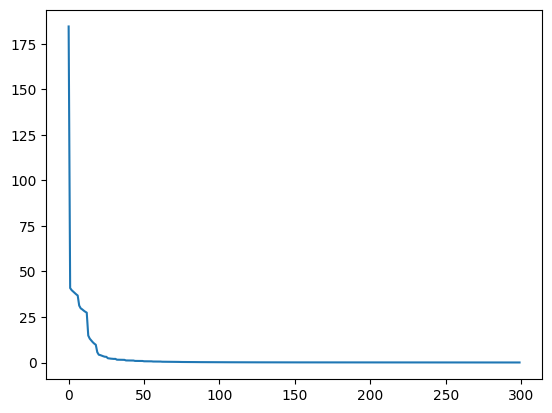

In [581]:
plt.plot(unitary_errors_array.flatten())

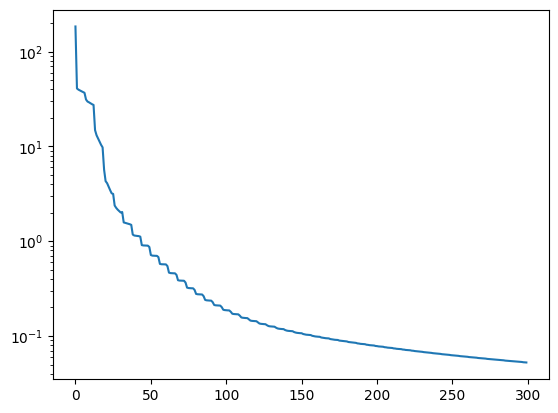

In [582]:
plt.plot(unitary_errors_array.flatten())
plt.yscale('log')

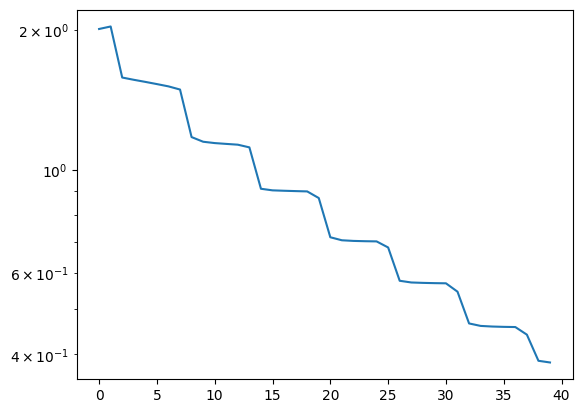

In [583]:
plt.plot(unitary_errors_array.flatten()[30:70])
plt.yscale('log')

In [584]:
unitary_errors_array[0]

array([184.47320431,  40.88739384,  39.74805653,  39.02509448,
        38.22326206,  37.47392485])

In [585]:
unitary_errors_array[-1]

array([0.05351   , 0.05328495, 0.05317873, 0.05281768, 0.0526645 ,
       0.05253319])

### Case 2

In [586]:
num_sites = 6

In [587]:
total_dimension = 2**num_sites

In [588]:
learning_rate = 0.001

In [589]:
num_iterations = 50

In [590]:
physical_dims = [2,]*num_sites
virtual_dims = [(None, 4),] + [(4,4)]*(num_sites -2) + [(4, None),]

In [591]:
perturbation_w_tensors = get_random_mpo_tensors(num_sites, 0.01)

In [592]:
identity_w_tensors = get_identity_mpo_tensors(physical_dims, virtual_dims)

In [593]:
mpo_frobenius_inner_product(perturbation_w_tensors)

0.010000000000000009

In [594]:
mpo_frobenius_inner_product(identity_w_tensors)

64.0

In [595]:
np.sqrt(mpo_frobenius_inner_product(perturbation_w_tensors)) + np.sqrt(mpo_frobenius_inner_product(identity_w_tensors))

8.1

In [596]:
w_tensors = [
    w1 + w2
    for w1, w2 in zip(identity_w_tensors, perturbation_w_tensors)
]

In [597]:
mpo_frobenius_inner_product(w_tensors)

174.08151944195174

In [598]:
np.sqrt(mpo_frobenius_inner_product(w_tensors))

13.193995582913908

In [600]:
mpo_frobenius_inner_product(identity_w_tensors)

64.0

In [601]:
total_dimension

64

In [602]:
unitary_errors = list()

In [603]:
for i_iteration in range(num_iterations):
    o2, o4 = unitary_mpo_gradient_descent_sweep(w_tensors, learning_rate)

    unitarity_errors = unitarity_errors_from_subscores(
        o2, o4, total_dimension
    )

    unitary_errors.append(unitarity_errors)

In [604]:
unitary_errors_array = np.array(unitary_errors)

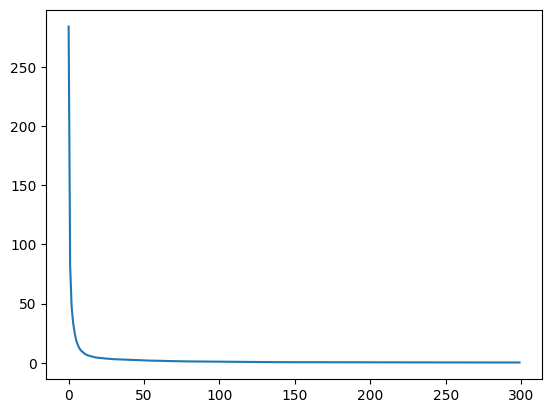

In [605]:
plt.plot(unitary_errors_array.flatten())

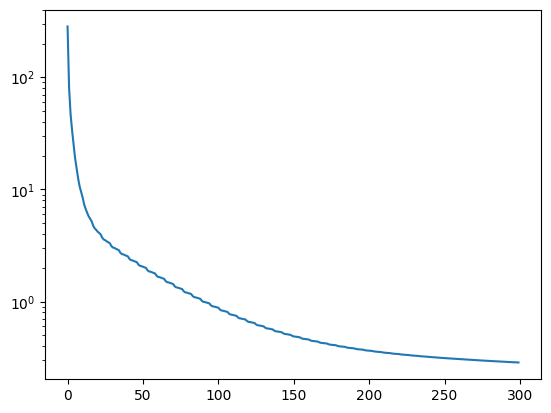

In [606]:
plt.plot(unitary_errors_array.flatten())
plt.yscale('log')

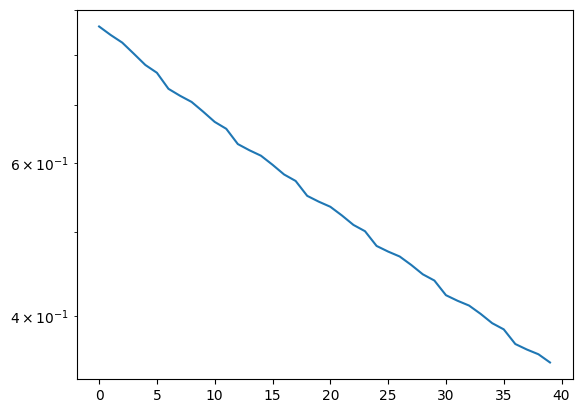

In [456]:
plt.plot(unitary_errors_array.flatten()[30:70])
plt.yscale('log')

In [607]:
unitary_errors_array[0]

array([284.00434753,  81.26500548,  46.92363231,  33.55063284,
        25.10147759,  18.96517949])

In [608]:
unitary_errors_array[-1]

array([0.28825841, 0.28750726, 0.28714188, 0.28657957, 0.28628898,
       0.28585104])

# Conclusions
* Performing gradient descent from an arbitrary MPO to a unitary can be quite challenging, likely due to the cubic terms in the gradient.
* When initialising at a random MPO, convergence is very sensitive to magnitude of said MPO, again likely due to cubic terms.
* The optimal strategy seems to be keeping relatively close to a unitary (namely the identity) to begin with.